In [2]:
# Cell 1: imports & basic settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from result_analysis import *

# Show more columns/rows if needed
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [3]:
# Cell 2: load result CSV

# log return
csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
df = pd.read_csv(csv_path)

# Try to parse date column if exists
if "date" in df.columns:
    try:
        df["date"] = pd.to_datetime(df["date"])
    except Exception as e:
        print("Warning: cannot parse date column:", e)

df.head()


,date,true_0,true_1,true_2,true_3,true_4,true_5,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5
0,2017-05-02,-0.003376,-0.013014,-0.007891,0.006681,0.001210,-0.013186,0.000526,0.002958,-0.000507,-0.001844,0.005581,0.004926
1,2017-05-03,-0.013014,-0.007891,0.006681,0.001210,-0.013186,0.007325,-0.001048,0.000816,-0.000287,-0.000690,0.010107,0.001655
2,2017-05-04,-0.007891,0.006681,0.001210,-0.013186,0.007325,-0.009983,0.001072,0.002626,-0.000806,0.000906,0.007584,-0.004441
3,2017-05-05,0.006681,0.001210,-0.013186,0.007325,-0.009983,-0.024457,0.000811,0.002727,0.003107,0.003160,0.000370,-0.001641
4,2017-05-08,0.001210,-0.013186,0.007325,-0.009983,-0.024457,0.003352,0.003133,0.004732,0.000951,-0.006825,0.006944,-0.002612


In [3]:
# Cell 3: helper function to compute metrics

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Compute basic regression and directional metrics.
    y_true, y_pred: 1D numpy arrays
    Returns a dict with mse, mae, rmse, r2, corr, direction_acc, n
    """
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {
            "n": 0,
            "mse": np.nan,
            "mae": np.nan,
            "rmse": np.nan,
            "r2": np.nan,
            "corr": np.nan,
            "direction_acc": np.nan,
        }

    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)

    # R^2
    var = np.var(y_true)
    if var == 0:
        r2 = np.nan
    else:
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    # Pearson correlation
    if len(y_true) > 1:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
    else:
        corr = np.nan

    # Direction accuracy (ignore zero returns)
    dir_mask = (y_true != 0)
    if dir_mask.sum() > 0:
        direction_acc = np.mean(
            np.sign(y_true[dir_mask]) == np.sign(y_pred[dir_mask])
        )
    else:
        direction_acc = np.nan

    return {
        "n": len(y_true),
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "corr": corr,
        "direction_acc": direction_acc,
    }


In [4]:
# Cell 4: compute per-horizon and global metrics

# Define horizon mapping
horizons = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

all_true = []
all_pred = []

rows = []

print("====== Per-horizon metrics (true_3/4/5 vs pred_0/1/2) ======")
for h_name, (t_col, p_col) in horizons.items():
    if t_col not in df.columns or p_col not in df.columns:
        print(f"[WARN] columns {t_col} or {p_col} not found, skip {h_name}")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    all_true.append(y_true)
    all_pred.append(y_pred)

    metrics = compute_metrics(y_true, y_pred)
    rows.append(
        {
            "horizon": h_name,
            **metrics,
        }
    )

    print(
        f"{h_name}: n={metrics['n']}, "
        f"MSE={metrics['mse']:.6f}, "
        f"MAE={metrics['mae']:.6f}, "
        f"RMSE={metrics['rmse']:.6f}, "
        f"R2={metrics['r2']:.4f}, "
        f"Corr={metrics['corr']:.4f}, "
        f"DirAcc={metrics['direction_acc']:.4f}"
    )

# Global metrics: flatten all horizons together
if all_true:
    y_true_all = np.concatenate(all_true)
    y_pred_all = np.concatenate(all_pred)
    global_metrics = compute_metrics(y_true_all, y_pred_all)
    rows.append(
        {
            "horizon": "Global(H+1~H+3)",
            **global_metrics,
        }
    )
    print("\n====== Global metrics (H+1~H+3 flattened) ======")
    print(
        f"Global: n={global_metrics['n']}, "
        f"MSE={global_metrics['mse']:.6f}, "
        f"MAE={global_metrics['mae']:.6f}, "
        f"RMSE={global_metrics['rmse']:.6f}, "
        f"R2={global_metrics['r2']:.4f}, "
        f"Corr={global_metrics['corr']:.4f}, "
        f"DirAcc={global_metrics['direction_acc']:.4f}"
    )

metrics_df = pd.DataFrame(rows)
metrics_df


====== Per-horizon metrics (true_3/4/5 vs pred_0/1/2) ======
H+1: n=2131, MSE=0.000781, MAE=0.016734, RMSE=0.027939, R2=-0.0387, Corr=-0.0413, DirAcc=0.5082
H+2: n=2131, MSE=0.000770, MAE=0.016635, RMSE=0.027750, R2=-0.0247, Corr=0.0120, DirAcc=0.5275
H+3: n=2131, MSE=0.000774, MAE=0.016613, RMSE=0.027821, R2=-0.0299, Corr=-0.0612, DirAcc=0.5218

====== Global metrics (H+1~H+3 flattened) ======
Global: n=6393, MSE=0.000775, MAE=0.016660, RMSE=0.027837, R2=-0.0311, Corr=-0.0294, DirAcc=0.5192


,horizon,n,mse,mae,rmse,r2,corr,direction_acc
0,H+1,2131,0.000781,0.016734,0.027939,-0.038708,-0.041315,0.508212
1,H+2,2131,0.000770,0.016635,0.027750,-0.024682,0.012019,0.527452
2,H+3,2131,0.000774,0.016613,0.027821,-0.029859,-0.061164,0.521821
3,Global(H+1~H+3),6393,0.000775,0.016660,0.027837,-0.031083,-0.029406,0.519162


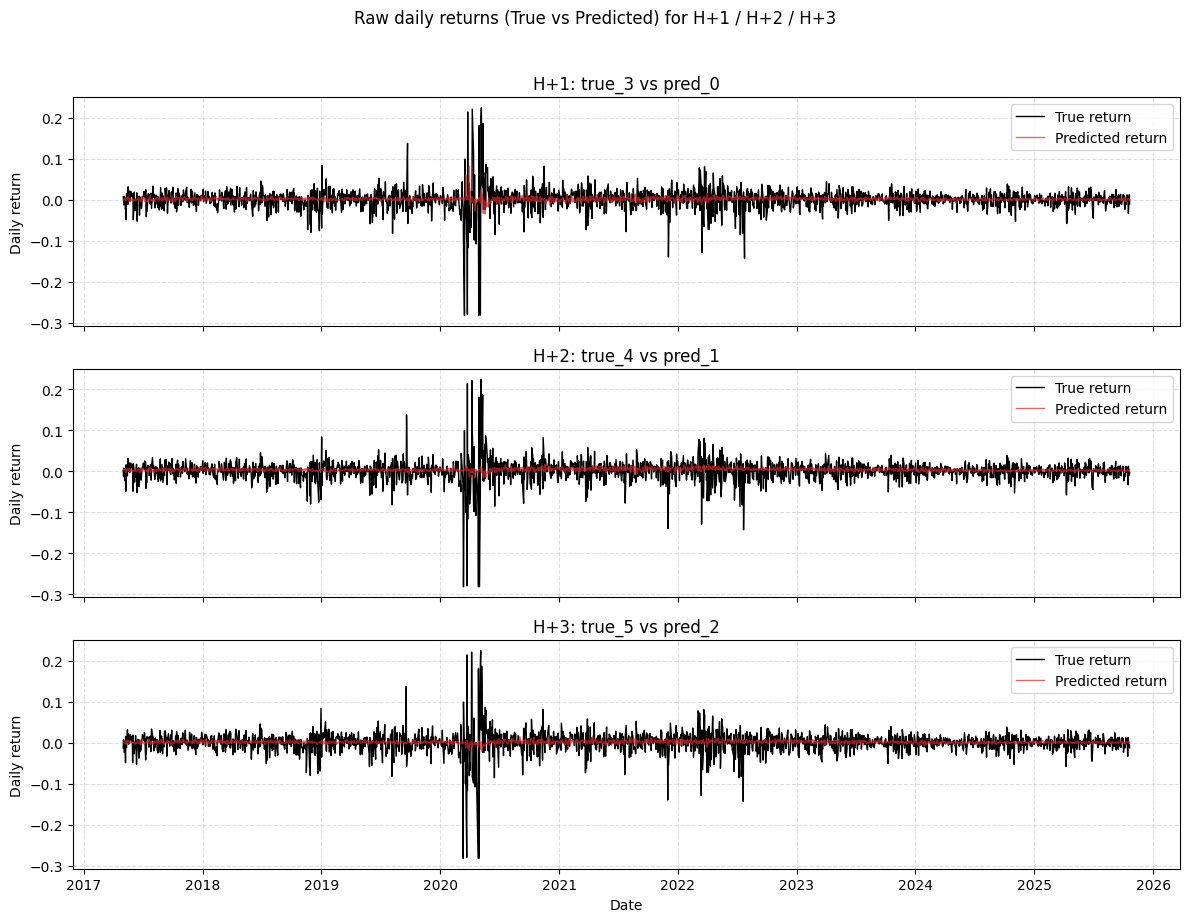

In [5]:
# Cell X: plot raw (non-cumulative) returns for H+1 / H+2 / H+3

import matplotlib.pyplot as plt
import numpy as np

# 映射关系
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# 创建三张子图（每个 horizon 一张）
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    ax.plot(x, y_true, label="True return", color="black", linewidth=1)
    ax.plot(x, y_pred, label="Predicted return", color="tab:red", linewidth=1, alpha=0.7)

    ax.set_title(f"{h_name}: {t_col} vs {p_col}")
    ax.set_ylabel("Daily return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle("Raw daily returns (True vs Predicted) for H+1 / H+2 / H+3", y=1.02)
plt.tight_layout()
plt.show()


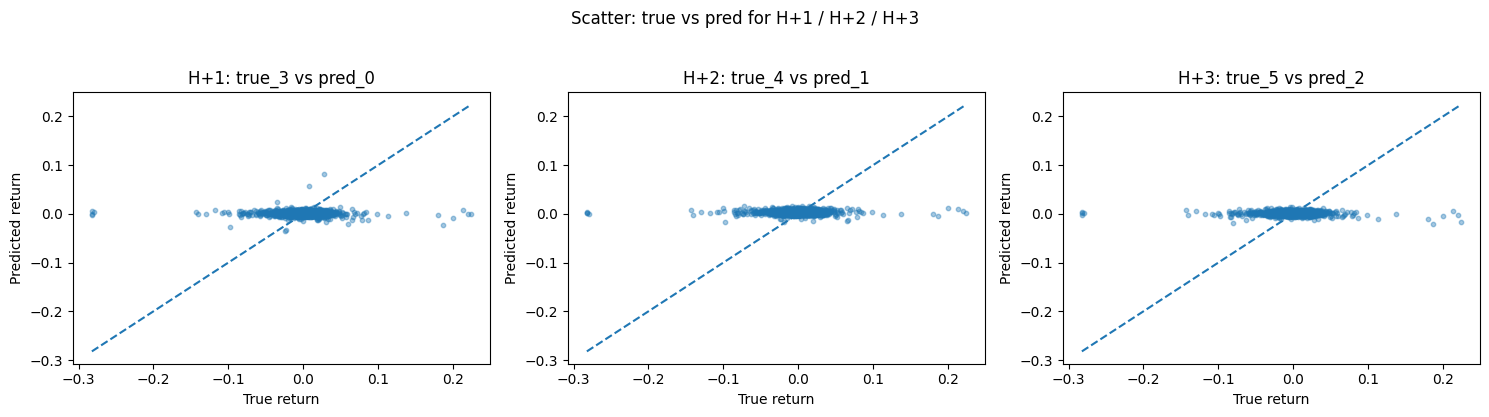

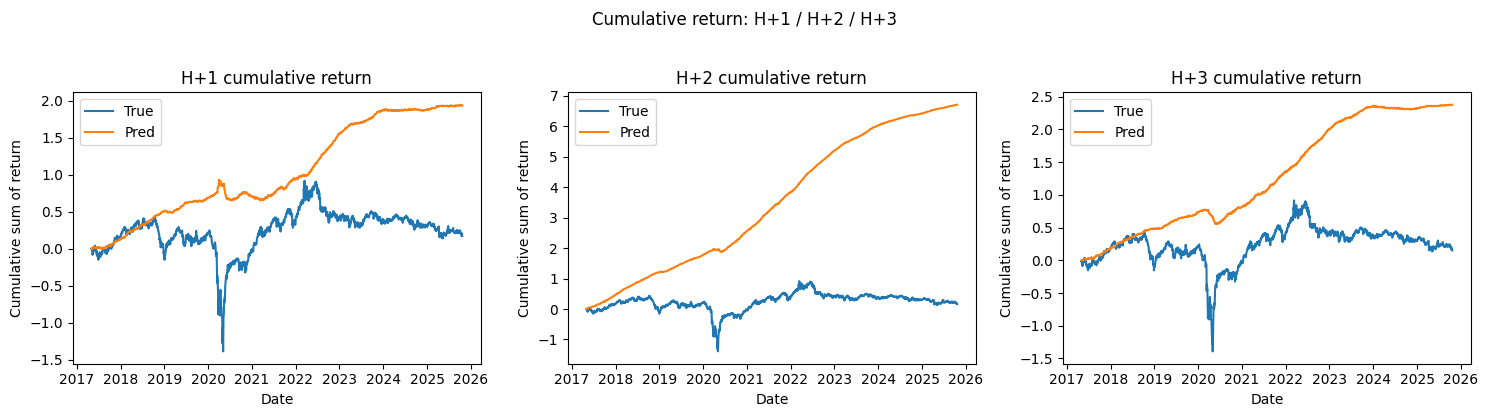

In [6]:
# Cell X: 3 horizons (H+1, H+2, H+3) scatter + cumulative return plots
import numpy as np
import matplotlib.pyplot as plt

# 映射关系：
#   H+1: true_3 vs pred_0
#   H+2: true_4 vs pred_1
#   H+3: true_5 vs pred_2
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# ========= 1) 三个 horizon 的散点图 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid points")
        ax.axis("off")
        continue

    ax.scatter(y_true, y_pred, alpha=0.4, s=10)

    # 画 y=x 参考线
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

    ax.set_xlabel("True return")
    ax.set_ylabel("Predicted return")
    ax.set_title(f"{h_name}: {t_col} vs {p_col}")

fig.suptitle("Scatter: true vs pred for H+1 / H+2 / H+3", y=1.03)
plt.tight_layout()
plt.show()


# ========= 2) 三个 horizon 的累计收益曲线 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid points")
        ax.axis("off")
        continue

    cum_true = np.cumsum(y_true)
    cum_pred = np.cumsum(y_pred)

    ax.plot(x, cum_true, label="True")
    ax.plot(x, cum_pred, label="Pred")

    ax.set_title(f"{h_name} cumulative return")
    ax.set_xlabel("Date" if has_date else "Index")
    ax.set_ylabel("Cumulative sum of return")
    ax.legend()

fig.suptitle("Cumulative return: H+1 / H+2 / H+3", y=1.03)
plt.tight_layout()
plt.show()


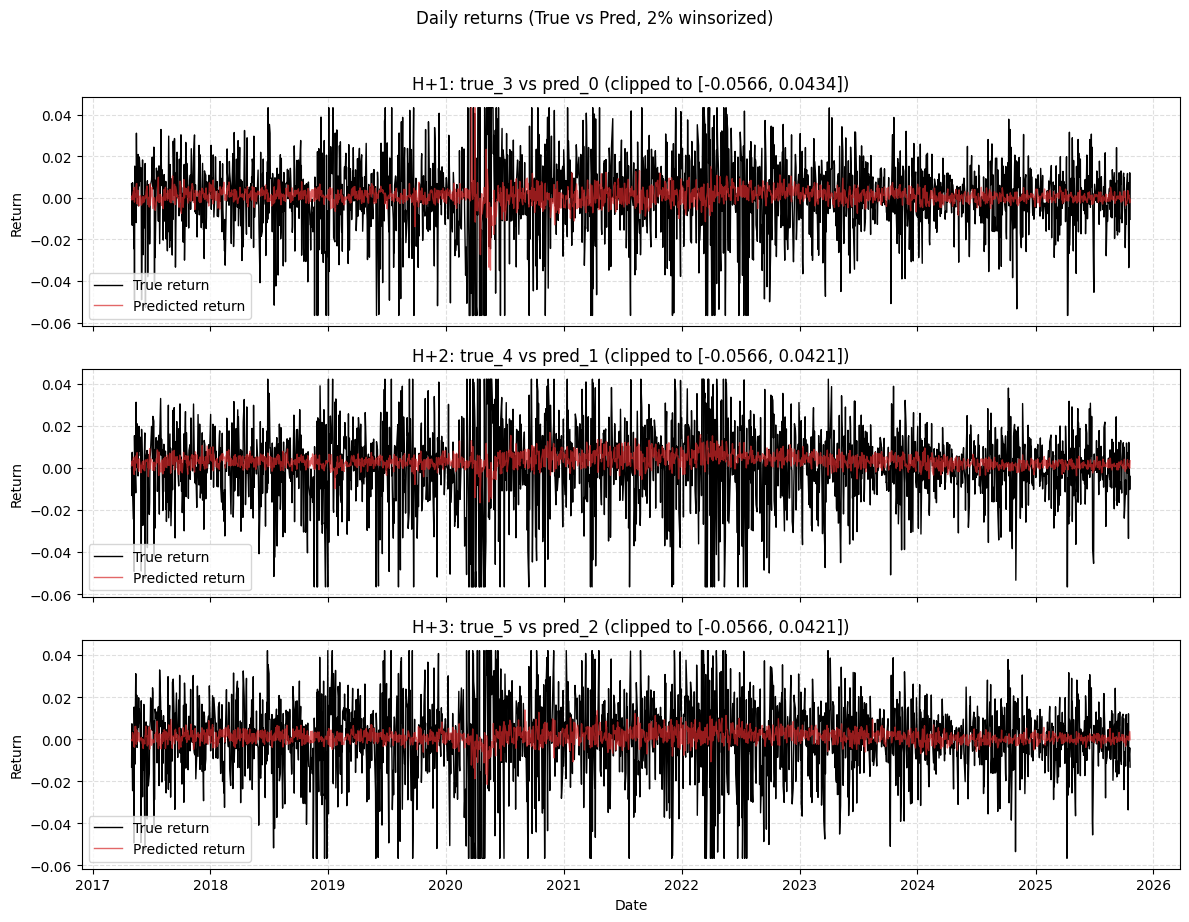

In [7]:
# Cell X: plot raw returns with outlier clipping (winsorized)

import matplotlib.pyplot as plt
import numpy as np

horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# -------- 可调参数：去极值百分比 --------
lower_pct, upper_pct = 1, 99  # 保留中间 98% 的数据
# --------------------------------------

def clip_outliers(y_true, y_pred, low, high):
    """对 y_true 和 y_pred 同时 clip 到指定分位数范围"""
    combined = np.concatenate([y_true, y_pred])
    lower, upper = np.percentile(combined, [low, high])
    return np.clip(y_true, lower, upper), np.clip(y_pred, lower, upper), (lower, upper)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    # 去除极端值
    y_true_clipped, y_pred_clipped, bounds = clip_outliers(y_true, y_pred, lower_pct, upper_pct)
    lower, upper = bounds

    ax.plot(x, y_true_clipped, label="True return", color="black", linewidth=1)
    ax.plot(x, y_pred_clipped, label="Predicted return", color="tab:red", linewidth=1, alpha=0.7)
    ax.set_title(f"{h_name}: {t_col} vs {p_col} (clipped to [{lower:.4f}, {upper:.4f}])")
    ax.set_ylabel("Return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle(f"Daily returns (True vs Pred, {100-upper_pct+lower_pct:.0f}% winsorized)", y=1.02)
plt.tight_layout()
plt.show()


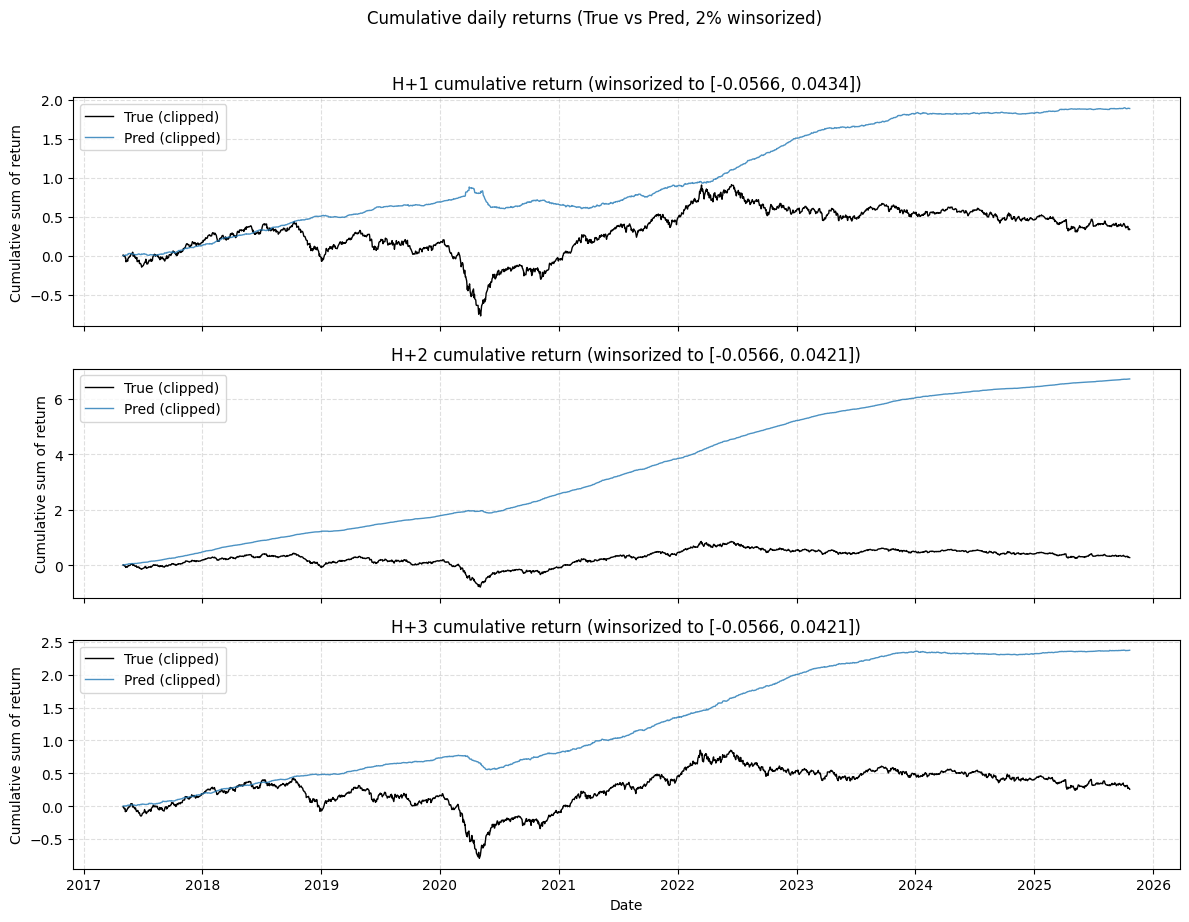

In [8]:
# Cell X: cumulative return (winsorized) for H+1 / H+2 / H+3

import numpy as np
import matplotlib.pyplot as plt

# 映射关系：预测的是 true_3/4/5，对应 pred_0/1/2
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# -------- 可调参数：去极值百分比 --------
lower_pct, upper_pct = 1, 99  # 保留中间 98% 的 return
# --------------------------------------

def clip_outliers(y_true, y_pred, low, high):
    """
    对 y_true 和 y_pred 同时做 winsorize：
    按联合分布计算分位数，然后把两边的 tail 裁到 [low, high] 区间。
    """
    combined = np.concatenate([y_true, y_pred])
    lower, upper = np.percentile(combined, [low, high])
    return np.clip(y_true, lower, upper), np.clip(y_pred, lower, upper), (lower, upper)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    # 去极值（winsorize）
    y_true_clip, y_pred_clip, bounds = clip_outliers(y_true, y_pred, lower_pct, upper_pct)
    lower, upper = bounds

    # 这里用 cumulative sum 近似累计收益（如果是 log-return 就正好是累计 log-return）
    cum_true = np.cumsum(y_true_clip)
    cum_pred = np.cumsum(y_pred_clip)

    # 👉 如果你想看“资金曲线”，可以改成：
    # equity_true = np.cumprod(1 + y_true_clip) - 1
    # equity_pred = np.cumprod(1 + y_pred_clip) - 1
    # 然后把下面的 cum_true/cum_pred 换成 equity_true/equity_pred

    ax.plot(x, cum_true, label="True (clipped)", color="black", linewidth=1)
    ax.plot(x, cum_pred, label="Pred (clipped)", color="tab:blue", linewidth=1, alpha=0.8)

    ax.set_title(
        f"{h_name} cumulative return (winsorized to [{lower:.4f}, {upper:.4f}])"
    )
    ax.set_ylabel("Cumulative sum of return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle(
    f"Cumulative daily returns (True vs Pred, {100-upper_pct+lower_pct:.0f}% winsorized)",
    y=1.02
)
plt.tight_layout()
plt.show()


In [9]:
from result_analysis import *

[INFO] Loaded 2131 rows from /home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_TimeMixer_TimeMixer_custom_ftMS_sl512_ll0_pl6_dm16_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Exp_0/data_table.csv

=== Per-horizon metrics (log-return space) ===
 horizon true_col pred_col  n_samples      MSE      MAE        R2     Corr
       1   true_3   pred_0       2131 0.001063 0.021412 -0.415013 0.095225
       2   true_4   pred_1       2131 0.001005 0.020971 -0.337692 0.108245
       3   true_5   pred_2       2131 0.000835 0.018684 -0.110620 0.136493


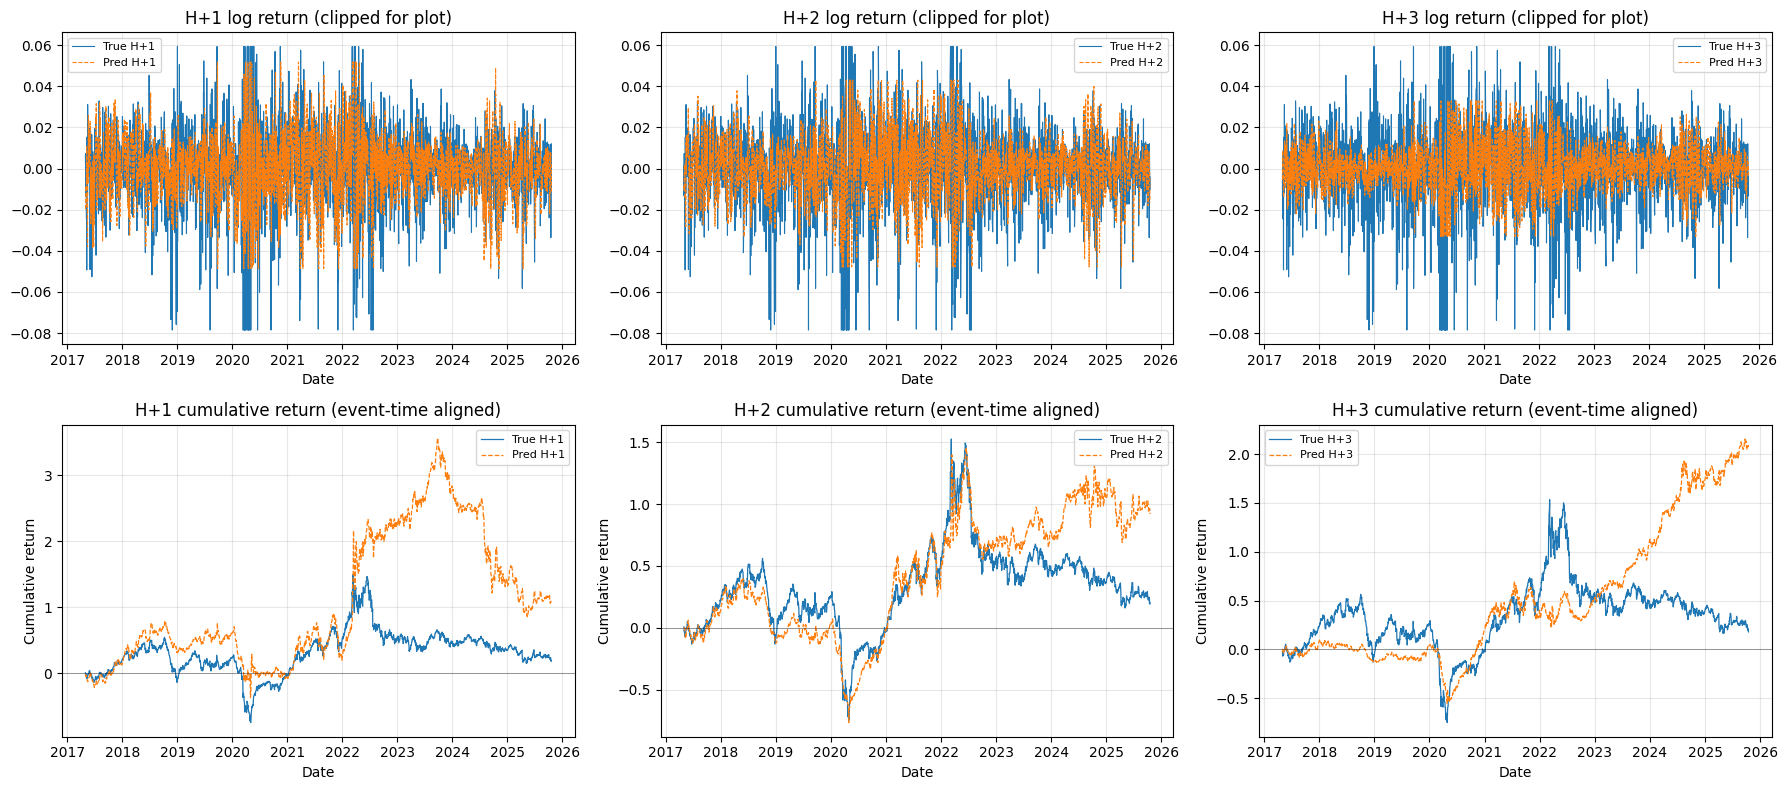

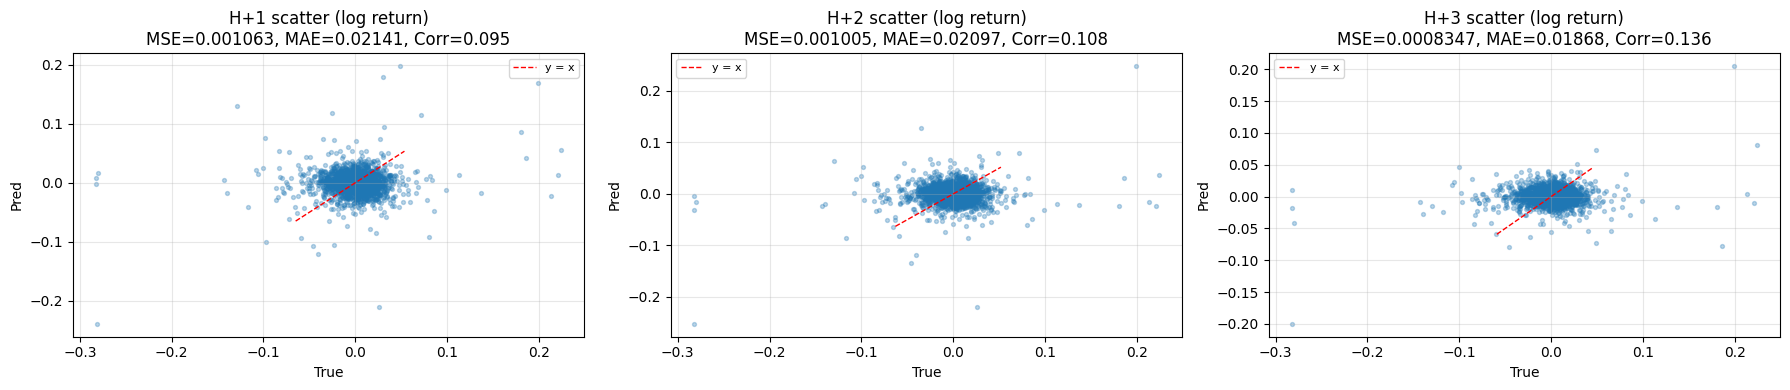

In [ ]:
# TimeMixer
metrics_timemixer = analyze_log_return_multi_horizon("/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_TimeMixer_TimeMixer_custom_ftMS_sl512_ll0_pl6_dm16_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Exp_0/data_table.csv", 
                           )

[INFO] Loaded 2131 rows from /home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv

=== Per-horizon metrics (log-return space) ===
 horizon true_col pred_col  n_samples      MSE      MAE        R2      Corr
       1   true_3   pred_0       2131 0.000781 0.016734 -0.038708 -0.041315
       2   true_4   pred_1       2131 0.000770 0.016635 -0.024682  0.012019
       3   true_5   pred_2       2131 0.000774 0.016613 -0.029859 -0.061164


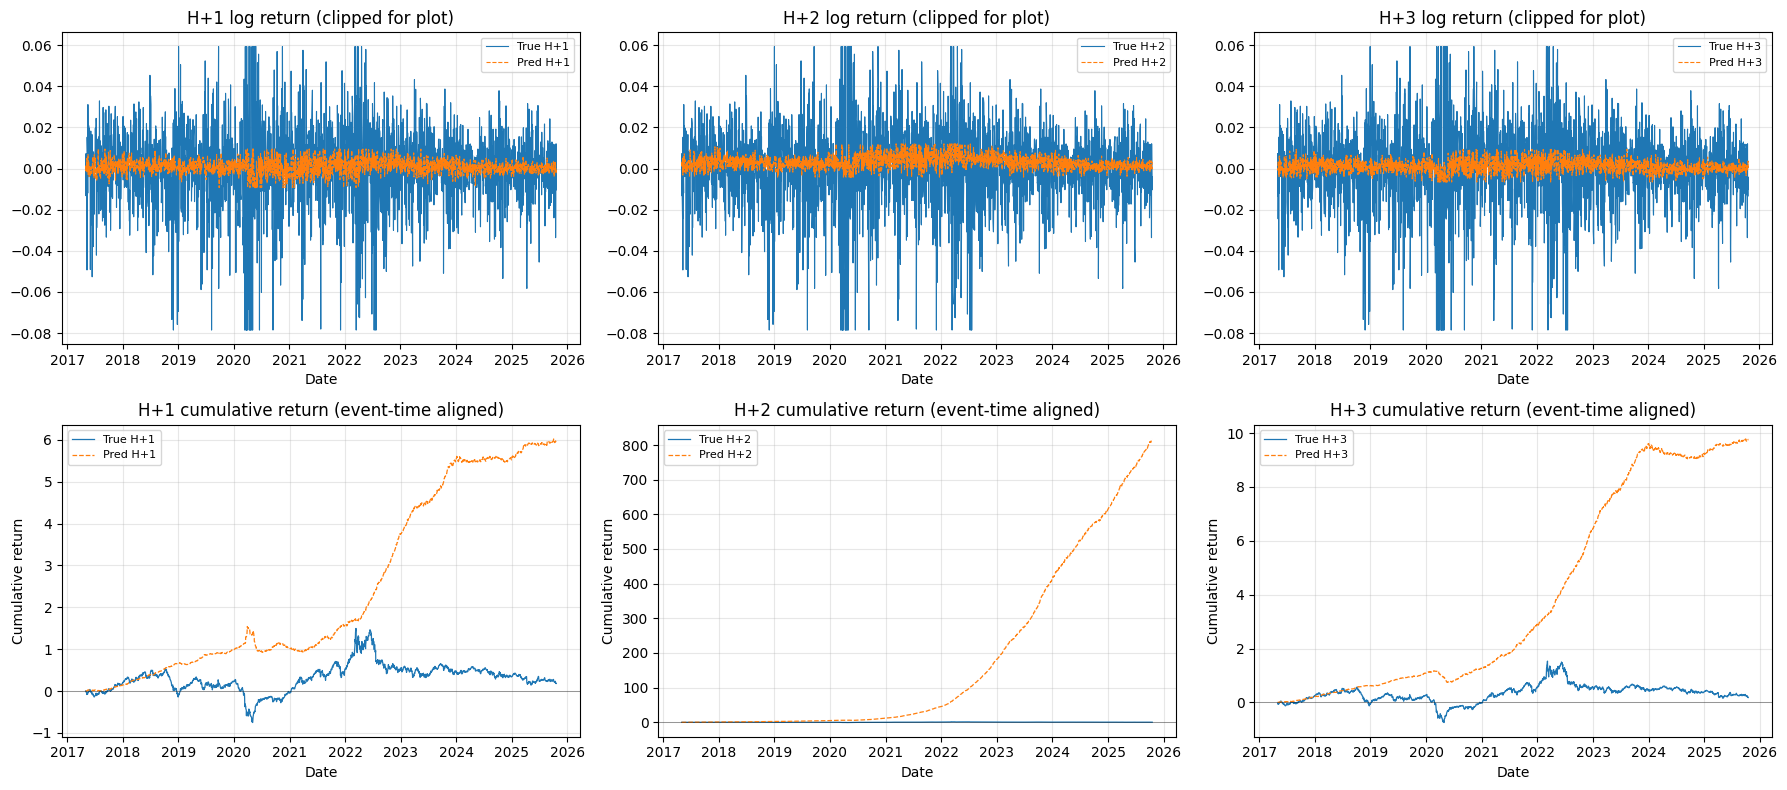

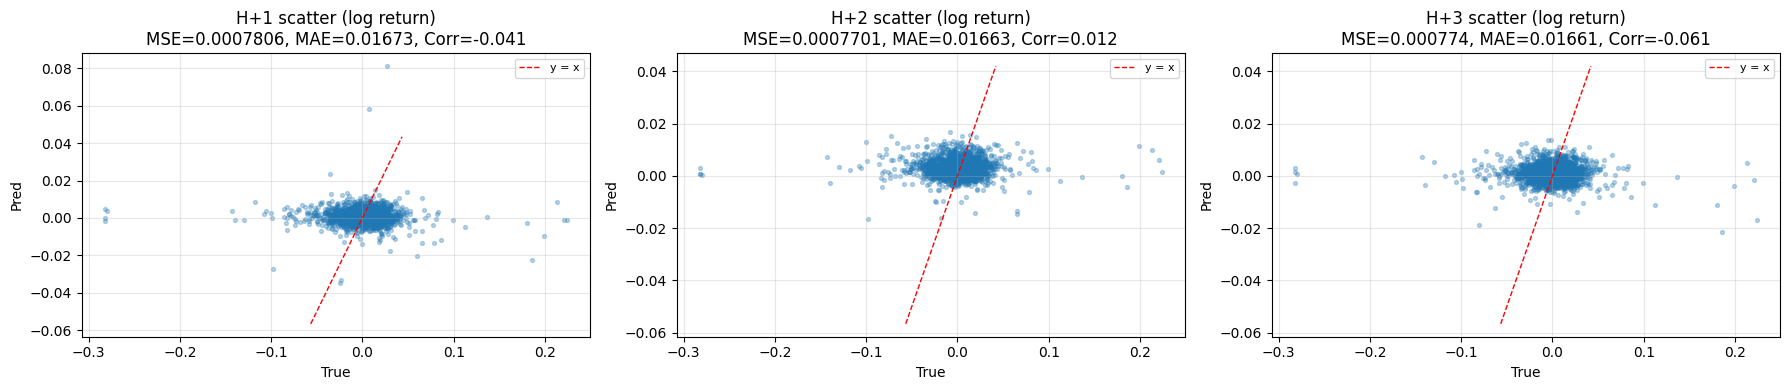

In [16]:
# PatchTST
patchtst_metrics = analyze_log_return_multi_horizon(csv_path)

[INFO] Loaded 2131 rows from /home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_Transformer_Transformer_custom_ftMS_sl512_ll48_pl6_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc1_ebtimeF_dtTrue_Exp_0/data_table.csv

=== Per-horizon metrics (log-return space) ===
 horizon true_col pred_col  n_samples      MSE      MAE        R2      Corr
       1   true_3   pred_0       2131 0.000755 0.016385 -0.004145 -0.000994
       2   true_4   pred_1       2131 0.000757 0.016368 -0.006804  0.023539
       3   true_5   pred_2       2131 0.000756 0.016370 -0.005982  0.019924


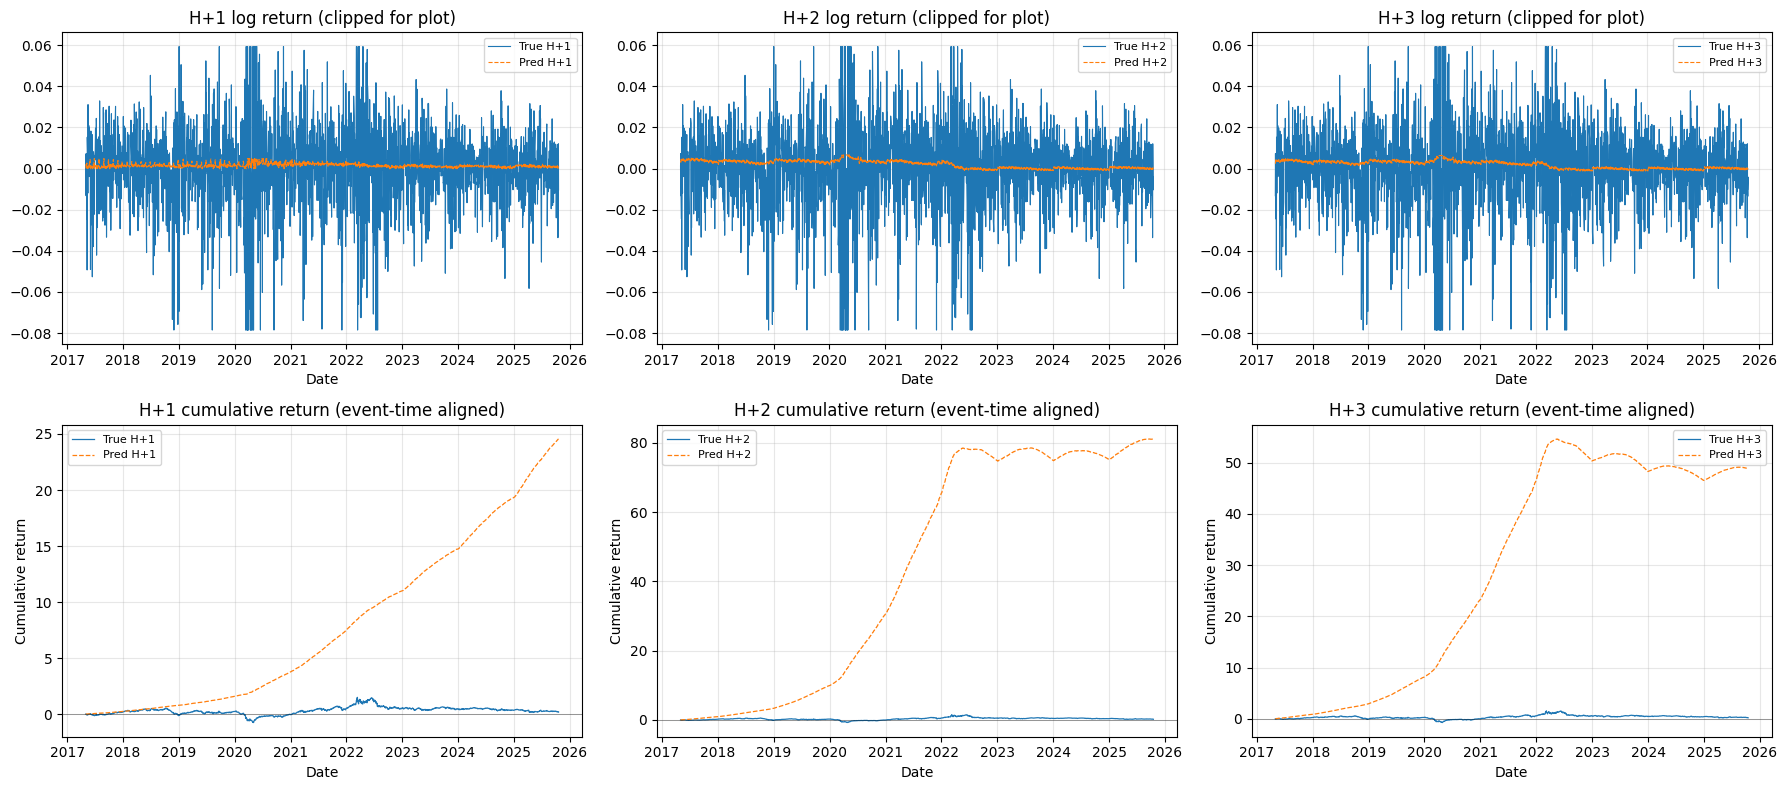

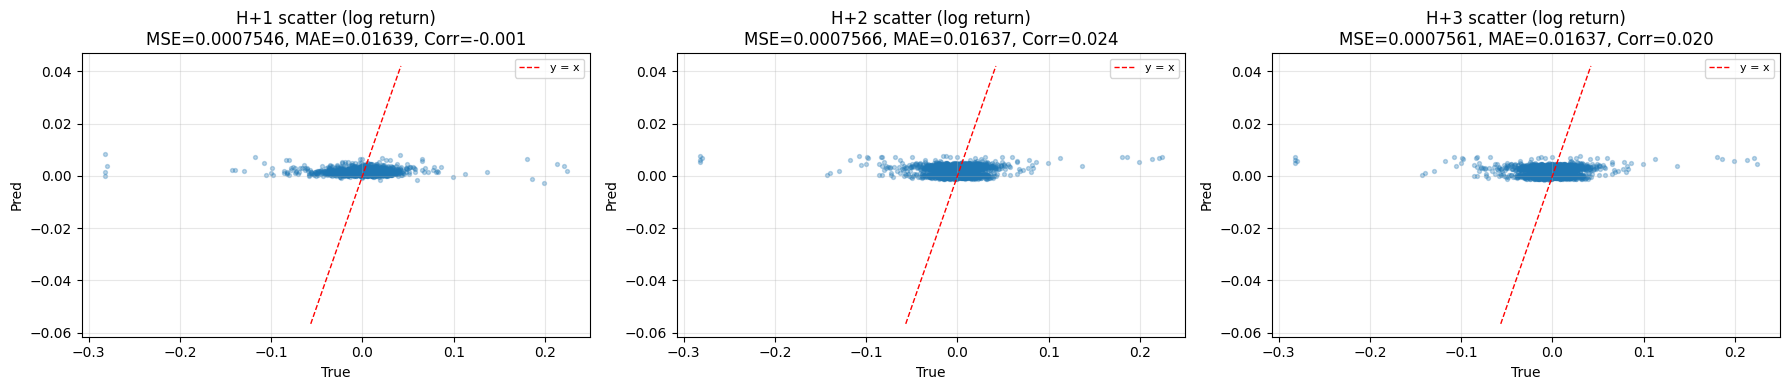

In [18]:
# Transformer
transformer_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_Transformer_Transformer_custom_ftMS_sl512_ll48_pl6_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc1_ebtimeF_dtTrue_Exp_0/data_table.csv"
transformer_metrics = analyze_log_return_multi_horizon(transformer_path)

[INFO] Loaded 2131 rows from /home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_TSMixer_TSMixer_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv

=== Per-horizon metrics (log-return space) ===
 horizon true_col pred_col  n_samples      MSE      MAE        R2     Corr
       1   true_3   pred_0       2131 0.000759 0.016609 -0.009364 0.024234
       2   true_4   pred_1       2131 0.000751 0.016500  0.001260 0.057770
       3   true_5   pred_2       2131 0.000761 0.016615 -0.012621 0.014592


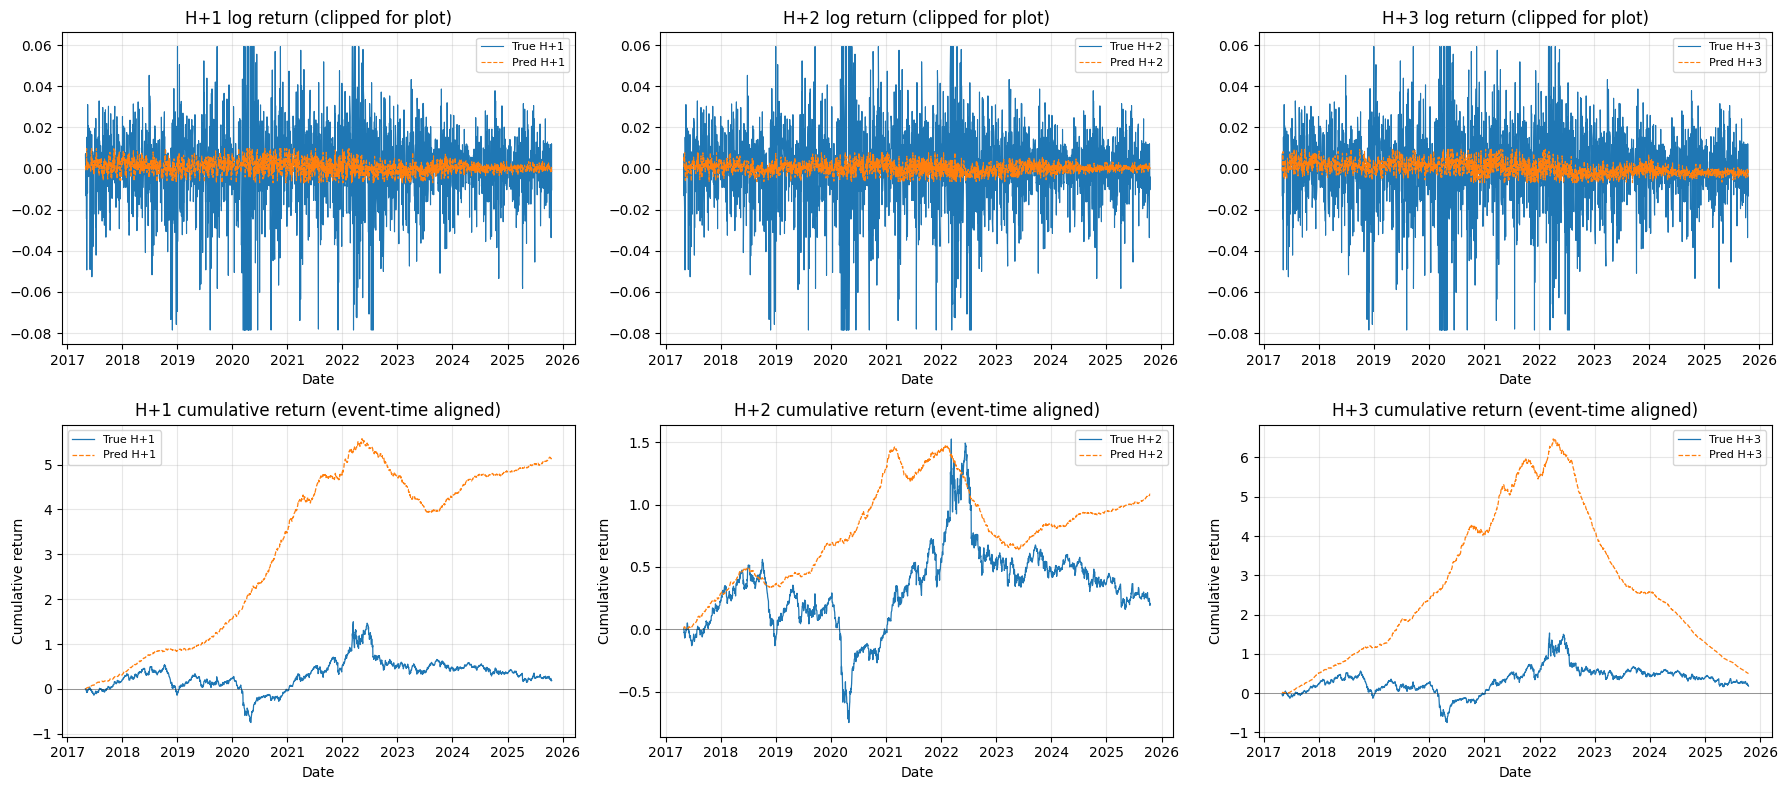

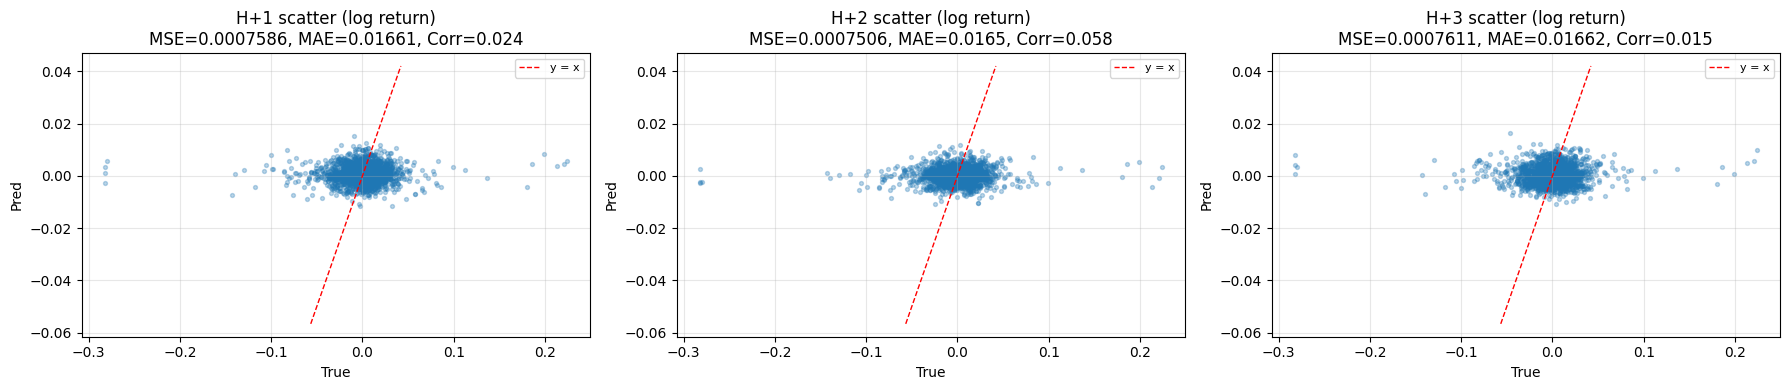

In [19]:
# TSMixer
ts_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_TSMixer_TSMixer_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
tsmixer_metrics = analyze_log_return_multi_horizon(ts_path)

## Momentum

In [4]:
## Regression
import numpy as np
import statsmodels.api as sm

horizons = [0, 1, 2]

for h in horizons:
    y = df[f"true_{h+3}"].to_numpy()
    x = df[f"pred_{h}"].to_numpy()

    # 去掉 NaN
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # 相关系数
    corr = np.corrcoef(x, y)[0, 1]

    # OLS 回归 y = α + β x
    X = sm.add_constant(x)   # 添加截距
    model = sm.OLS(y, X).fit()

    beta = model.params[1]
    tval = model.tvalues[1]
    pval = model.pvalues[1]
    r2   = model.rsquared

    print(f"=== Horizon {h} ===")
    print(f"Corr(true_{h+3}, pred_{h}) = {corr:.4f}")
    print(f"beta = {beta:.4f}, t = {tval:.2f}, p = {pval:.3g}, R^2 = {r2:.4f}")
    print()


=== Horizon 0 ===
Corr(true_3, pred_0) = -0.0413
beta = -0.2624, t = -1.91, p = 0.0565, R^2 = 0.0017

=== Horizon 1 ===
Corr(true_4, pred_1) = 0.0120
beta = 0.0979, t = 0.55, p = 0.579, R^2 = 0.0001

=== Horizon 2 ===
Corr(true_5, pred_2) = -0.0612
beta = -0.5177, t = -2.83, p = 0.00474, R^2 = 0.0037



In [5]:
import numpy as np

horizons = [0, 1, 2]

for h in horizons:
    y = df[f"true_{h+3}"].to_numpy()
    x = df[f"pred_{h}"].to_numpy()

    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    sign_pred = np.sign(x)
    sign_true = np.sign(y)

    # 只看非零情况（可以选）
    nonzero = (sign_pred != 0) & (sign_true != 0)
    sign_pred = sign_pred[nonzero]
    sign_true = sign_true[nonzero]

    directional_hits = (sign_pred == sign_true).mean()

    print(f"=== Horizon {h} ===")
    print(f"Directional accuracy = {directional_hits:.4%}  (non-zero only)")
    print(f"Sample size = {len(sign_pred)}")
    print()


=== Horizon 0 ===
Directional accuracy = 50.8212%  (non-zero only)
Sample size = 2131

=== Horizon 1 ===
Directional accuracy = 52.7452%  (non-zero only)
Sample size = 2131

=== Horizon 2 ===
Directional accuracy = 52.1821%  (non-zero only)
Sample size = 2131



In [6]:
import numpy as np
import pandas as pd

horizons = [0, 1, 2]

for h in horizons:
    sub = df[[f"true_{h+3}", f"pred_{h}"]].copy()
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna()

    true_col = f"true_{h+3}"
    pred_col = f"pred_{h}"

    sub["pred_sign"] = np.sign(sub[pred_col])

    mean_pos = sub.loc[sub["pred_sign"] > 0, true_col].mean()
    mean_neg = sub.loc[sub["pred_sign"] < 0, true_col].mean()
    mean_all = sub[true_col].mean()

    print(f"=== Horizon {h} ===")
    print(f"Mean true return | pred>0: {mean_pos:.6f} (n={len(sub[sub['pred_sign']>0])})")
    print(f"Mean true return | pred<0: {mean_neg:.6f} (n={len(sub[sub['pred_sign']<0])})")
    print(f"Mean true return (overall): {mean_all:.6f} (n={len(sub)})")
    print()


=== Horizon 0 ===
Mean true return | pred>0: -0.000797 (n=1307)
Mean true return | pred<0: 0.001477 (n=824)
Mean true return (overall): 0.000082 (n=2131)

=== Horizon 1 ===
Mean true return | pred>0: -0.000209 (n=1817)
Mean true return | pred<0: 0.001730 (n=314)
Mean true return (overall): 0.000077 (n=2131)

=== Horizon 2 ===
Mean true return | pred>0: -0.000430 (n=1366)
Mean true return | pred<0: 0.000964 (n=765)
Mean true return (overall): 0.000070 (n=2131)



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

horizons = [0, 1, 2]

for h in horizons:
    y = df[f"true_{h+3}"].to_numpy()
    x = df[f"pred_{h}"].to_numpy()

    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # label: 1 = up, 0 = down 或 flat
    y_true_cls = (y > 0).astype(int)
    y_pred_cls = (x > 0).astype(int)

    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print(f"=== Horizon {h} ===")
    print("Confusion matrix [[TN, FP], [FN, TP]]:")
    print(cm)
    print("Classification report:")
    print(classification_report(y_true_cls, y_pred_cls, digits=3))
    print()


=== Horizon 0 ===
Confusion matrix [[TN, FP], [FN, TP]]:
[[388 599]
 [436 708]]
Classification report:
              precision    recall  f1-score   support

           0      0.471     0.393     0.428       987
           1      0.542     0.619     0.578      1144

    accuracy                          0.514      2131
   macro avg      0.506     0.506     0.503      2131
weighted avg      0.509     0.514     0.509      2131


=== Horizon 1 ===
Confusion matrix [[TN, FP], [FN, TP]]:
[[151 836]
 [163 981]]
Classification report:
              precision    recall  f1-score   support

           0      0.481     0.153     0.232       987
           1      0.540     0.858     0.663      1144

    accuracy                          0.531      2131
   macro avg      0.510     0.505     0.447      2131
weighted avg      0.513     0.531     0.463      2131


=== Horizon 2 ===
Confusion matrix [[TN, FP], [FN, TP]]:
[[362 624]
 [403 742]]
Classification report:
              precision    recall  

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ---------- 读数据 & 预处理 ----------
# 如果已经有 df 就不用这一行
# csv_path = "your_path.csv"
# df = pd.read_csv(csv_path)

# 确保 date 是 datetime
if "date" in df.columns and not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"])

# 加 year 列
df["year"] = df["date"].dt.year

horizons = [0, 1, 2]

reg_rows = []    # 方法1结果
da_rows  = []    # 方法2结果
cond_rows = []   # 方法3结果

years = sorted(df["year"].unique())
years_plus_all = years + ["All"]

for year in years_plus_all:
    if year == "All":
        sub = df.copy()
    else:
        sub = df[df["year"] == year].copy()
    
    # 去掉 inf
    sub = sub.replace([np.inf, -np.inf], np.nan)
    
    for h in horizons:
        true_col = f"true_{h+3}"
        pred_col = f"pred_{h}"
        if true_col not in sub.columns or pred_col not in sub.columns:
            continue
        
        y = sub[true_col].to_numpy()
        x = sub[pred_col].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        if len(x) < 5:
            continue
        
        # ========= 方法 1：相关 + 回归 =========
        corr = np.corrcoef(x, y)[0, 1]
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        beta = model.params[1]
        tval = model.tvalues[1]
        pval = model.pvalues[1]
        r2   = model.rsquared
        
        # 判定是否 momentum：beta>0 且 显著
        is_momentum_reg = bool((beta > 0) and (pval < 0.1))
        
        reg_rows.append({
            "year": year,
            "horizon": h,
            "n": len(x),
            "corr": corr,
            "beta": beta,
            "t_beta": tval,
            "p_beta": pval,
            "R2": r2,
            "is_momentum_reg": is_momentum_reg
        })
        
        # ========= 方法 2：Directional Accuracy =========
        sign_pred = np.sign(x)
        sign_true = np.sign(y)
        nonzero = (sign_pred != 0) & (sign_true != 0)
        
        if nonzero.sum() > 0:
            da = (sign_pred[nonzero] == sign_true[nonzero]).mean()
        else:
            da = np.nan
        
        # 判定是否 momentum：命中率 > 50%
        is_momentum_da = bool(da > 0.5) if np.isfinite(da) else False
        
        da_rows.append({
            "year": year,
            "horizon": h,
            "n_nonzero": int(nonzero.sum()),
            "directional_accuracy": da,
            "is_momentum_da": is_momentum_da
        })
        
        # ========= 方法 3：条件期望 + std =========
        sub2 = pd.DataFrame({"true": y, "pred": x})
        sub2["pred_sign"] = np.sign(sub2["pred"])
        
        mask_pos = sub2["pred_sign"] > 0
        mask_neg = sub2["pred_sign"] < 0
        
        mean_pos = sub2.loc[mask_pos, "true"].mean() if mask_pos.any() else np.nan
        mean_neg = sub2.loc[mask_neg, "true"].mean() if mask_neg.any() else np.nan
        mean_all = sub2["true"].mean()
        
        std_pos = sub2.loc[mask_pos, "true"].std(ddof=1) if mask_pos.any() else np.nan
        std_neg = sub2.loc[mask_neg, "true"].std(ddof=1) if mask_neg.any() else np.nan
        
        # 分别判断是否 momentum：
        #   pred>0 时真实均值 > 0
        #   pred<0 时真实均值 < 0
        is_mom_pos = bool(mean_pos > 0) if np.isfinite(mean_pos) else False
        is_mom_neg = bool(mean_neg < 0) if np.isfinite(mean_neg) else False
        is_mom_overall = is_mom_pos and is_mom_neg
        
        cond_rows.append({
            "year": year,
            "horizon": h,
            "n_pos": int(mask_pos.sum()),
            "n_neg": int(mask_neg.sum()),
            "mean_true_pred_pos": mean_pos,
            "mean_true_pred_neg": mean_neg,
            "mean_true_overall": mean_all,
            "std_true_pred_pos": std_pos,
            "std_true_pred_neg": std_neg,
            "is_momentum_pos": is_mom_pos,
            "is_momentum_neg": is_mom_neg,
            "is_momentum_overall": is_mom_overall
        })

# ---------- 转成 DataFrame ----------
df_reg  = pd.DataFrame(reg_rows)
df_da   = pd.DataFrame(da_rows)
df_cond = pd.DataFrame(cond_rows)

print("=== 方法1：回归 & 相关系数 ===")
display(df_reg)

print("=== 方法2：Directional Accuracy ===")
display(df_da)

print("=== 方法3：条件期望 + std ===")
display(df_cond)


=== 方法1：回归 & 相关系数 ===


,year,horizon,n,corr,beta,t_beta,p_beta,R2,is_momentum_reg
0,2017,0,169,0.126632,0.632779,1.649721,0.100880,0.016036,False
1,2017,1,169,0.073561,0.407371,0.953194,0.341869,0.005411,False
2,2017,2,169,0.105239,0.573380,1.367579,0.173282,0.011075,False
3,2018,0,252,0.055059,0.401601,0.871877,0.384112,0.003031,False
4,2018,1,252,0.107941,0.889793,1.716731,0.087267,0.011651,True
5,2018,2,252,0.116164,0.954486,1.849236,0.065604,0.013494,True
6,2019,0,252,-0.078576,-0.671874,-1.246243,0.213842,0.006174,False
7,2019,1,252,-0.064738,-0.573084,-1.025745,0.306003,0.004191,False
8,2019,2,252,-0.070473,-0.633323,-1.117054,0.265044,0.004966,False
9,2020,0,251,-0.072855,-0.472715,-1.152699,0.250139,0.005308,False


=== 方法2：Directional Accuracy ===


,year,horizon,n_nonzero,directional_accuracy,is_momentum_da
0,2017,0,169,0.573964,True
1,2017,1,169,0.556213,True
2,2017,2,169,0.568047,True
3,2018,0,252,0.507937,True
4,2018,1,252,0.515873,True
5,2018,2,252,0.539683,True
6,2019,0,252,0.515873,True
7,2019,1,252,0.523810,True
8,2019,2,252,0.535714,True
9,2020,0,251,0.482072,False


=== 方法3：条件期望 + std ===


,year,horizon,n_pos,n_neg,mean_true_pred_pos,mean_true_pred_neg,mean_true_overall,std_true_pred_pos,std_true_pred_neg,is_momentum_pos,is_momentum_neg,is_momentum_overall
0,2017,0,99,70,0.003147,-0.002021,0.001007,0.015073,0.017239,True,True,True
1,2017,1,136,33,0.001016,0.000823,0.000978,0.016738,0.013706,True,False,False
2,2017,2,106,63,0.002294,-0.000852,0.001121,0.015991,0.016648,True,True,True
3,2018,0,181,71,-0.000944,-0.001072,-0.000980,0.019133,0.016671,False,True,False
4,2018,1,226,26,-0.000791,-0.005368,-0.001263,0.018779,0.020179,False,True,False
5,2018,2,174,78,-0.000156,-0.002991,-0.001033,0.020141,0.018310,False,True,False
6,2019,0,156,96,0.000492,0.002152,0.001124,0.022840,0.021913,True,False,False
7,2019,1,213,39,0.000389,0.007170,0.001438,0.020141,0.029994,True,False,False
8,2019,2,166,86,0.000656,0.002090,0.001145,0.018339,0.026446,True,False,False
9,2020,0,128,123,-0.009584,0.008110,-0.000913,0.056410,0.058899,False,False,False


In [ ]:
# 先 merge 三个结果表
merged = (
    df_reg[["year", "horizon", "beta", "p_beta"]]
    .merge(df_da[["year", "horizon", "directional_accuracy"]],
           on=["year", "horizon"], how="inner")
    .merge(df_cond[["year", "horizon",
                    "mean_true_pred_pos", "mean_true_pred_neg"]],
           on=["year", "horizon"], how="inner")
)

# 定义基础布尔条件
beta_mom = (merged["beta"] > 0) & (merged["p_beta"] < 0.1)
beta_rev = (merged["beta"] < 0) & (merged["p_beta"] < 0.1)

da_mom = merged["directional_accuracy"] > 0.5
da_rev = merged["directional_accuracy"] < 0.5

cond_mom = (merged["mean_true_pred_pos"] > 0) & (merged["mean_true_pred_neg"] < 0)
cond_rev = (merged["mean_true_pred_pos"] < 0) & (merged["mean_true_pred_neg"] > 0)

# 初始化标签为 "neither"
merged["signal_type"] = "neither"

# 先标 reversion，再标 momentum（顺序无所谓，只要保证互斥）
merged.loc[beta_rev & (da_rev | cond_rev), "signal_type"] = "mean_reversion"
merged.loc[beta_mom & (da_mom | cond_mom), "signal_type"] = "momentum"

merged


,year,horizon,beta,p_beta,directional_accuracy,mean_true_pred_pos,mean_true_pred_neg,signal_type
0,2017,0,-0.248911,0.520858,0.485207,0.000546,0.001014,neither
1,2017,1,-0.125763,0.769948,0.497041,0.000325,0.002713,neither
2,2017,2,-0.117474,0.779626,0.514793,0.002009,-0.000879,neither
3,2018,0,0.494794,0.280446,0.531746,0.000221,-0.003550,neither
4,2018,1,0.011380,0.982068,0.559524,-0.000270,-0.005222,neither
5,2018,2,0.351029,0.472987,0.515873,-0.000208,-0.002562,neither
6,2019,0,0.327314,0.546996,0.480159,0.000390,0.002240,neither
7,2019,1,-0.001469,0.997955,0.555556,0.001117,0.000569,neither
8,2019,2,-0.156051,0.793783,0.527778,0.001545,0.000223,neither
9,2020,0,0.839009,0.040496,0.509960,-0.004655,0.003089,momentum


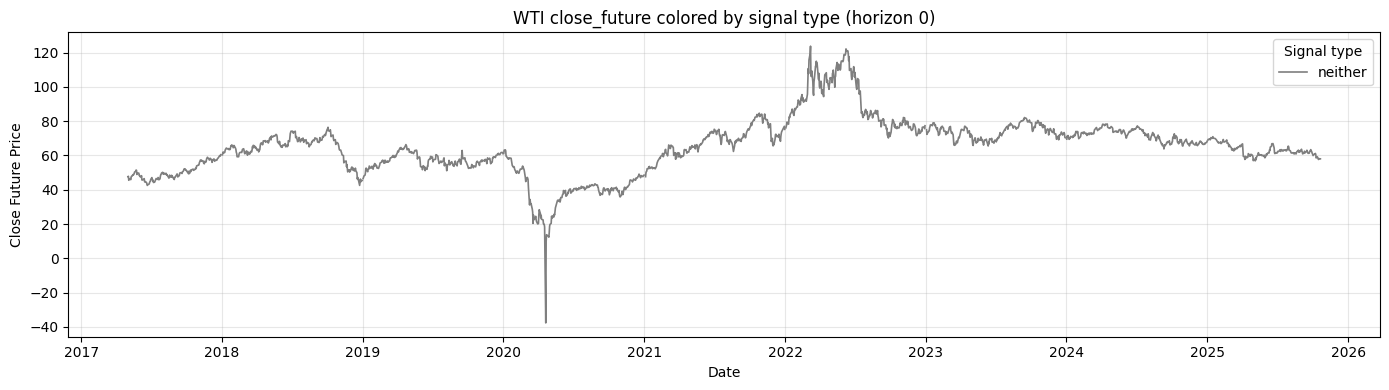

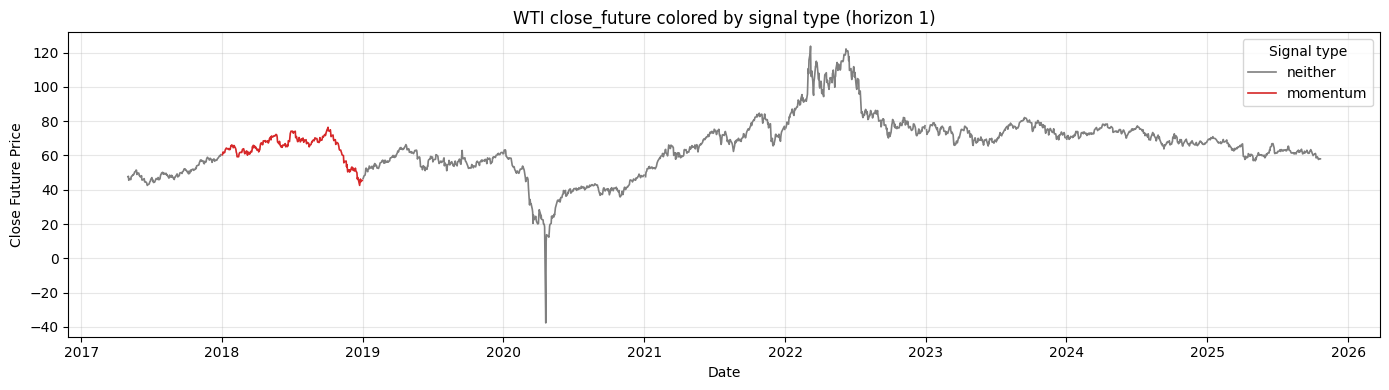

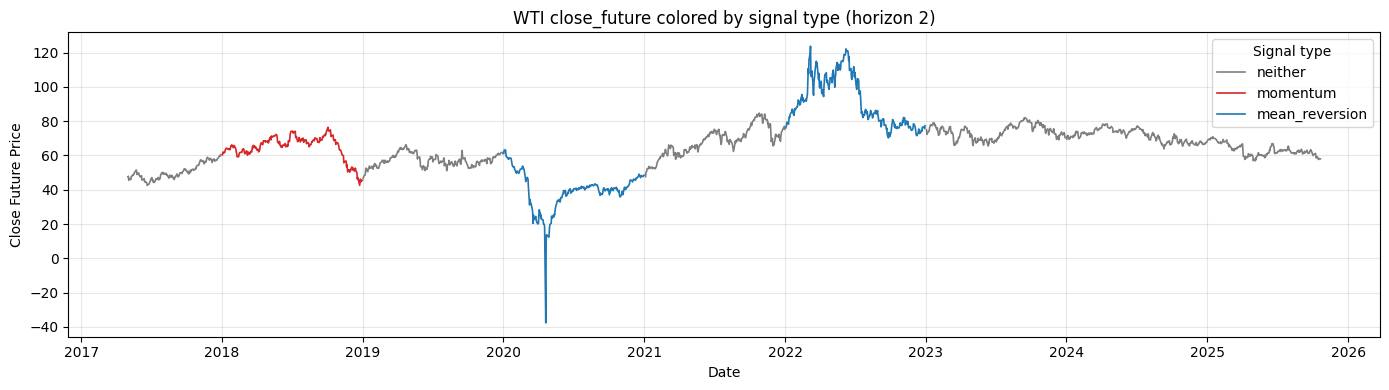

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ===================== 1. Load model result table =====================

# Result table with date, true_0..true_k, pred_0..pred_k
result_csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
df = pd.read_csv(result_csv_path)

# Parse date and add year column
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# We only use horizons 0,1,2
horizons = [0, 1, 2]

# ===================== 2. Per-year metrics for methods 1/2/3 =====================

reg_rows = []    # method 1: regression stats
da_rows  = []    # method 2: directional accuracy
cond_rows = []   # method 3: conditional means

years = sorted(df["year"].unique())
years_plus_all = years + ["All"]  # keep "All" for overall stats if you want

for year in years_plus_all:
    # Slice data for a single year, or use all years
    if year == "All":
        sub = df.copy()
    else:
        sub = df[df["year"] == year].copy()
    sub = sub.replace([np.inf, -np.inf], np.nan)

    for h in horizons:
        true_col = f"true_{h+3}"
        pred_col = f"pred_{h}"
        if true_col not in sub.columns or pred_col not in sub.columns:
            continue

        y = sub[true_col].to_numpy()
        x = sub[pred_col].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        if len(x) < 5:
            continue

        # ---------- Method 1: Regression (true = a + b * pred) ----------
        corr = np.corrcoef(x, y)[0, 1]
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        beta = model.params[1]
        pval = model.pvalues[1]
        tval = model.tvalues[1]
        r2   = model.rsquared

        reg_rows.append({
            "year": year,
            "horizon": h,
            "n": len(x),
            "corr": corr,
            "beta": beta,
            "p_beta": pval,
            "t_beta": tval,
            "R2": r2
        })

        # ---------- Method 2: Directional accuracy ----------
        sign_pred = np.sign(x)
        sign_true = np.sign(y)
        nonzero = (sign_pred != 0) & (sign_true != 0)
        if nonzero.sum() > 0:
            da = (sign_pred[nonzero] == sign_true[nonzero]).mean()
        else:
            da = np.nan

        da_rows.append({
            "year": year,
            "horizon": h,
            "n_nonzero": int(nonzero.sum()),
            "directional_accuracy": da
        })

        # ---------- Method 3: Conditional means given pred sign ----------
        sub2 = pd.DataFrame({"true": y, "pred": x})
        sub2["pred_sign"] = np.sign(sub2["pred"])
        mask_pos = sub2["pred_sign"] > 0
        mask_neg = sub2["pred_sign"] < 0

        mean_pos = sub2.loc[mask_pos, "true"].mean() if mask_pos.any() else np.nan
        mean_neg = sub2.loc[mask_neg, "true"].mean() if mask_neg.any() else np.nan

        cond_rows.append({
            "year": year,
            "horizon": h,
            "mean_true_pred_pos": mean_pos,
            "mean_true_pred_neg": mean_neg
        })

df_reg  = pd.DataFrame(reg_rows)
df_da   = pd.DataFrame(da_rows)
df_cond = pd.DataFrame(cond_rows)

# ===================== 3. Merge and classify signal type =====================

merged = (
    df_reg[["year", "horizon", "beta", "p_beta"]]
    .merge(df_da[["year", "horizon", "directional_accuracy"]],
           on=["year", "horizon"], how="inner")
    .merge(df_cond[["year", "horizon",
                    "mean_true_pred_pos", "mean_true_pred_neg"]],
           on=["year", "horizon"], how="inner")
)

# Base boolean flags for momentum / mean-reversion from each method
beta_mom = (merged["beta"] > 0) & (merged["p_beta"] < 0.1)
beta_rev = (merged["beta"] < 0) & (merged["p_beta"] < 0.1)

da_mom = merged["directional_accuracy"] > 0.5
da_rev = merged["directional_accuracy"] < 0.5

cond_mom = (merged["mean_true_pred_pos"] > 0) & (merged["mean_true_pred_neg"] < 0)
cond_rev = (merged["mean_true_pred_pos"] < 0) & (merged["mean_true_pred_neg"] > 0)

# Final label: momentum / mean_reversion / neither
merged["signal_type"] = "neither"
merged.loc[beta_rev & (da_rev | cond_rev), "signal_type"] = "mean_reversion"
merged.loc[beta_mom & (da_mom | cond_mom), "signal_type"] = "momentum"

# Keep only real years (drop the "All" row for plotting)
merged_yearly = merged[merged["year"] != "All"].copy()
merged_yearly["year"] = merged_yearly["year"].astype(int)

# ===================== 4. Load original WTI price (WTI-log.csv) =====================

price_csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/dataset/FBD/WTI-log.csv"
price = pd.read_csv(price_csv_path)

price["date"] = pd.to_datetime(price["date"])

# Align date range with result df
start_date = df["date"].min()
end_date   = df["date"].max()
price = price[(price["date"] >= start_date) & (price["date"] <= end_date)].copy()

# ===================== 5. Plot close_future with yearly segments colored by signal type =====================

color_map = {
    "momentum": "tab:red",
    "mean_reversion": "tab:blue",
    "neither": "tab:gray",
}

for h in horizons:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.set_title(f"WTI close_future colored by signal type (horizon {h})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Future Price")

    cls_sub = merged_yearly[merged_yearly["horizon"] == h]

    used_labels = set()  # to avoid duplicate legend entries

    for _, row in cls_sub.iterrows():
        year = int(row["year"])
        sig  = row["signal_type"]
        color = color_map.get(sig, "tab:gray")

        mask_year = price["date"].dt.year == year
        x_year = price.loc[mask_year, "date"]
        y_year = price.loc[mask_year, "close_future"]

        label = sig if sig not in used_labels else "_nolegend_"
        ax.plot(x_year, y_year, color=color, linewidth=1.2, label=label)
        used_labels.add(sig)

    ax.legend(title="Signal type")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

# ===================== 1. Load data =====================

result_csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
price_csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/dataset/FBD/WTI-log.csv"

df = pd.read_csv(result_csv_path)
price = pd.read_csv(price_csv_path)

df["date"] = pd.to_datetime(df["date"])
price["date"] = pd.to_datetime(price["date"])

df = df.sort_values("date").reset_index(drop=True)
price = price.sort_values("date").reset_index(drop=True)

# merge daily_return and close
df = df.merge(price[["date","daily_return","close_future"]], on="date", how="left")

# ===================== 2. Settings =====================

horizons = [0,1,2]

window_beta  = 252     # rolling window for beta
window_beta_z = 252    # rolling z-score window for beta
window_trend = 60      # trend rolling window
window_zfactor = 252   # z-score of pred_factor/trend

# shift for horizons
shift_map = {0:1, 1:2, 2:3}

# weights for horizons
weights = {0:1.0, 1:1.0, 2:1.0}

# final mixing weight
alpha = 0.7

# ===================== 3. Rolling beta helper =====================

def compute_rolling_beta(true_s: pd.Series,
                         pred_s: pd.Series,
                         win: int) -> pd.Series:
    """
    Compute rolling beta = Cov(x,y)/Var(x) using past window of length win.
    Beta is shifted by 1 day to avoid lookahead.
    """
    x = pred_s
    y = true_s
    
    mean_x  = x.rolling(win, min_periods=win).mean()
    mean_y  = y.rolling(win, min_periods=win).mean()
    mean_xy = (x*y).rolling(win, min_periods=win).mean()
    mean_x2 = (x*x).rolling(win, min_periods=win).mean()

    var_x = mean_x2 - mean_x*mean_x
    cov_xy = mean_xy - mean_x*mean_y

    beta = cov_xy / var_x
    beta = beta.replace([np.inf,-np.inf], np.nan)
    
    # shift so beta_t uses info up to t-1
    beta = beta.shift(1)
    return beta

# ===================== 4. Per-horizon β, β_zscore, scaled =====================

beta_dict = {}
beta_z_dict = {}
scaled_dict = {}
comp_dict = {}

for h in horizons:
    true_col = f"true_{h+3}"
    pred_col = f"pred_{h}"
    
    y = df[true_col]
    x = df[pred_col]
    
    # rolling beta (no lookahead)
    beta_h = compute_rolling_beta(y, x, win=window_beta)
    
    # === NEW PART: strength = zscore(beta) ===
    beta_mean = beta_h.rolling(window_beta_z, min_periods=window_beta_z).mean()
    beta_std  = beta_h.rolling(window_beta_z, min_periods=window_beta_z).std(ddof=1)
    beta_z = (beta_h - beta_mean) / beta_std
    beta_z = beta_z.replace([np.inf,-np.inf], np.nan)
    
    # squash strength to [-1,1] for stability
    strength_h = np.tanh(beta_z)
    
    # scaled signal on same day
    scaled_h = x * beta_h * strength_h
    
    beta_dict[h] = beta_h
    beta_z_dict[h] = beta_z
    scaled_dict[h] = scaled_h

# ===================== 5. Time align horizons into one decision day =====================

for h in horizons:
    comp_dict[h] = scaled_dict[h].shift(shift_map[h])

pred_factor_raw = (
    weights[0]*comp_dict[0]
  + weights[1]*comp_dict[1]
  + weights[2]*comp_dict[2]
)

# ===================== 6. Trend signal (rolling mean of past returns) =====================

trend_raw = df["daily_return"].rolling(window_trend, min_periods=10).mean()
trend_raw = trend_raw.shift(1)  # avoid lookahead

# ===================== 7. Rolling z-score normalizations =====================

def rolling_z(series: pd.Series, win: int):
    mean = series.rolling(win, min_periods=win).mean()
    std  = series.rolling(win, min_periods=win).std(ddof=1)
    z = (series - mean) / std
    z = z.replace([np.inf,-np.inf], np.nan)
    return z

z_pred_factor = rolling_z(pred_factor_raw, window_zfactor)
z_trend       = rolling_z(trend_raw,      window_zfactor)

# ===================== 8. Final combined factor =====================

factor_total = alpha * z_pred_factor + (1 - alpha) * z_trend

# ===================== 9. Output dataframe =====================

factor_df = pd.DataFrame({
    "date": df["date"],
    
    # raw preds
    "pred_0": df["pred_3"],
    "pred_1": df["pred_4"],
    "pred_2": df["pred_5"],
    
    # betas
    "beta_0": beta_dict[0],
    "beta_1": beta_dict[1],
    "beta_2": beta_dict[2],
    
    # beta zscores
    "beta_z_0": beta_z_dict[0],
    "beta_z_1": beta_z_dict[1],
    "beta_z_2": beta_z_dict[2],
    
    # same-day scaled (pred * beta * strength)
    "scaled_0": scaled_dict[0],
    "scaled_1": scaled_dict[1],
    "scaled_2": scaled_dict[2],
    
    # aligned components for actual factor
    "comp_0": comp_dict[0],
    "comp_1": comp_dict[1],
    "comp_2": comp_dict[2],
    
    # pred-based factor
    "pred_factor_raw": pred_factor_raw,
    
    # trend
    "trend_raw": trend_raw,
    
    # z-normalized parts
    "z_pred_factor": z_pred_factor,
    "z_trend": z_trend,
    
    # final factor
    "factor_total": factor_total,
    
    # reference market data
    "daily_return": df["daily_return"],
    "close_future": df["close_future"],
})

factor_df.head()


,date,pred_0,pred_1,pred_2,beta_0,beta_1,beta_2,beta_z_0,beta_z_1,beta_z_2,scaled_0,scaled_1,scaled_2,comp_0,comp_1,comp_2,pred_factor_raw,trend_raw,z_pred_factor,z_trend,factor_total,daily_return,close_future
0,2017-05-02,0.000526,0.002958,-0.000507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013186,47.659989
1,2017-05-03,-0.001048,0.000816,-0.000287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007325,47.819993
2,2017-05-04,0.001072,0.002626,-0.000806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009983,45.519990
3,2017-05-05,0.000811,0.002727,0.003107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024457,46.219986
4,2017-05-08,0.003133,0.004732,0.000951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003352,46.429993


In [17]:
factor_df

,date,pred_0,pred_1,pred_2,beta_0,beta_1,beta_2,beta_z_0,beta_z_1,beta_z_2,scaled_0,scaled_1,scaled_2,comp_0,comp_1,comp_2,pred_factor_raw,trend_raw,z_pred_factor,z_trend,factor_total,daily_return,close_future
0,2017-05-02,0.000526,0.002958,-0.000507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013186,47.659989
1,2017-05-03,-0.001048,0.000816,-0.000287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007325,47.819993
2,2017-05-04,0.001072,0.002626,-0.000806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009983,45.519990
3,2017-05-05,0.000811,0.002727,0.003107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024457,46.219986
4,2017-05-08,0.003133,0.004732,0.000951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003352,46.429993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,2025-10-15,0.000068,0.001913,0.001216,-0.315847,-0.615665,-0.291742,-0.295492,-1.568177,-0.630768,0.000006,0.001080,0.000198,0.000123,0.001994,7.191585e-06,0.002124,-0.000523,1.096385,-0.068865,0.746810,-0.033588,58.410000
2127,2025-10-16,0.000732,0.001395,-0.000654,-0.311677,-0.629176,-0.293986,-0.281706,-1.587040,-0.638886,0.000063,0.000807,-0.000108,0.000006,0.000659,6.757074e-06,0.000672,-0.001253,0.056793,-0.769862,-0.191203,0.012053,57.640000
2128,2025-10-17,0.001445,0.000651,0.000385,-0.397859,-0.632831,-0.217265,-0.586198,-1.581723,-0.274754,0.000303,0.000378,0.000022,0.000063,0.001080,-1.296846e-07,0.001142,-0.001065,0.389899,-0.587877,0.096566,-0.010347,58.100000
2129,2025-10-20,-0.002415,-0.000235,0.003632,-0.421306,-0.517485,-0.203495,-0.664690,-1.325592,-0.210514,-0.000592,-0.000106,0.000153,0.000303,0.000807,1.982245e-04,0.001308,-0.001248,0.506548,-0.761317,0.126188,-0.004100,58.060000


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
def default_position_conversion(pred, threshold=0.):
    """
    Convert the prediction to position, default is 1 if prediction is greater than threshold, -1 otherwise;  this means your maximum exposure is 1 lot.
    pred: np.ndarray, the prediction of the asset
    threshold: float, the threshold of the prediction
    return: np.ndarray, the position of the asset
    """
    return np.where(pred > threshold, 1, -1)

def calculate_metrics(pnl):
    ret = np.concatenate([[pnl[0]], pnl])
    annualized_return = np.mean(ret) * 252 / len(ret)
    annualized_volatility = ret.std() * (np.sqrt(252) / np.sqrt(len(ret)))
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = np.max(np.cumsum(pnl) - np.maximum.accumulate(pnl))
    return{
        "annualized_return": annualized_return,
        "annualized_volatility": annualized_volatility,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown
    }

def backtest(true_ret, position, commission=0.0005):
    """
        true_ret: np.ndarray, the true return of the asset (this is what you are predicting)
        position: np.ndarray, the position of the asset (you should find a way to convert your prediction to position), i provide a default position conversion function above
        
    """
    assert (isinstance(true_ret, np.ndarray) and isinstance(position, np.ndarray)), "true_ret and position must be numpy arrays"
    assert len(true_ret) == len(position), "true_ret and position must have the same length"
    commission = commission * np.abs(np.concatenate([[position[0]], np.diff(position)])) * true_ret
    pnl = np.cumsum(true_ret * position - commission)
    hit_ratio = np.mean(true_ret * position > 0)
    metrics = calculate_metrics(pnl)
    metrics["hit_ratio"] = hit_ratio
    
    plt.figure(figsize=(10, 5))
    plt.plot(pnl)
    plt.title("PnL")
    plt.xlabel("Time")
    plt.ylabel("PnL")
    plt.show()
    return metrics

In [11]:
df['pred_3'].describe()

count    2131.000000
mean       -0.000668
std         0.003928
min        -0.082209
25%        -0.002482
50%        -0.000516
75%         0.001541
max         0.010137
Name: pred_3, dtype: float64

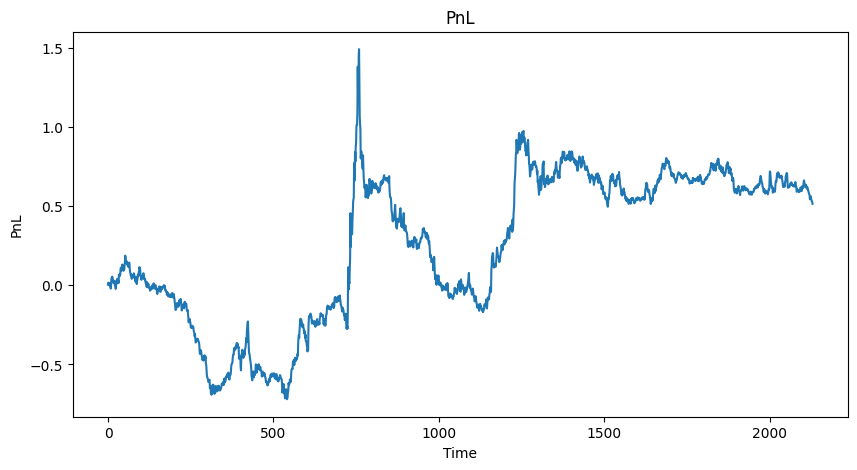

{'annualized_return': np.float64(0.029952499483416713),
 'annualized_volatility': np.float64(0.1605596297347838),
 'sharpe_ratio': np.float64(0.18655062628690014),
 'max_drawdown': np.float64(538.7710451021235),
 'hit_ratio': np.float64(0.4913186297512905)}

In [14]:
backtest(df['true_0'].values, default_position_conversion(df['pred_3']))